(line)=

# Fitting a model to data

If you're reading this right now then you're probably interested in using
emcee to fit a model to some noisy data.
On this page, I'll demonstrate how you might do this in the simplest
non-trivial model that I could think of: fitting a line to data when you
don't believe the error bars on your data.
The interested reader should check out [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686) for a much more complete discussion of how
to fit a line to data in The Real World™ and why MCMC might come in handy.

In [26]:
# %config InlineBackend.figure_format = "retina"

# from matplotlib import rcParams

# rcParams["savefig.dpi"] = 100
# rcParams["figure.dpi"] = 100
# rcParams["font.size"] = 20

In [22]:
import numpy as np
import os
import re

import CDEF

import scipy.optimize
from scipy.optimize import root, Bounds

import time

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, NullFormatter

from build123d import export_stl
from ocp_vscode import show


def bipyramid(fillet_radius, R, h, base_corners=5, center=(0,0,0), rotation=0.0):
    from build123d import Solid, Shell, Face, Wire, export_stl, fillet
    from scipy.spatial import ConvexHull
    import numpy as np

    def bipyramid_vertices(R, h, base_corners=5, center=(0,0,0), rotation=0.0):
        """Generate vertices of a bipyramid with a variable amount of base corners.

        Args:
            R (float): radius of the base.
            h (float): height of the apices above and below the base plane.
            center (tuple): (x, y, z) coordinates of the bipyramid center.
            rotation (float): rotation angle in radians applied to the base pentagon.

        Returns:
            List of 7 tuples [(x,y,z), ...] representing the bipyramid vertices.
        """
        cx, cy, cz = center
        vertices = []
        
        # 5 vertices of pentagonal base in XY plane with rotation
        for i in range(base_corners):
            angle = 2 * np.pi * i / base_corners + rotation
            x = cx + R * np.cos(angle)
            y = cy + R * np.sin(angle)
            z = cz
            vertices.append((x, y, z))
        
        # apex vertex at +h and -h
        vertices.append((cx, cy, cz + h))
        vertices.append((cx, cy, cz - h))
        
        return vertices

    vertices = bipyramid_vertices(R=R, h=h, base_corners=base_corners, center=center, rotation=rotation)

    # Create a convex hull from the vertices
    hull = ConvexHull(vertices).simplices.tolist()

    # Create faces from the vertex indices
    faces = []
    for face_vertex_indices in hull:
        corner_vertices = [vertices[i] for i in face_vertex_indices]
        faces.append(Face(Wire.make_polygon(corner_vertices)))

    # Create the solid from the Faces
    bipy = Solid(Shell(faces)).clean()
    if fillet_radius > 0:
        bipy = fillet(bipy.edges(), radius=fillet_radius)
    return bipy


def build123d_to_mesh(shape, tolerance=1e-3):
    all_tris = []
    for f in shape.faces():
        tess = f.tessellate(tolerance)
        # Case 1: tess returns (vertices, triangles)
        if isinstance(tess, tuple) and len(tess) == 2:
            vertices, triangles = tess
            # Convert each vertex to (x,y,z)
            coords = [ (v.X, v.Y, v.Z) if hasattr(v, "X") else tuple(v) for v in vertices ]
            for tri in triangles:
                all_tris.append([ coords[i] for i in tri ])
        # Case 2: tess returns list of triangles directly
        else:
            for tri in tess:
                # Convert each Vector to tuple if needed
                all_tris.append([ (v.X, v.Y, v.Z) if hasattr(v, "X") else tuple(v) for v in tri ])
    return np.array(all_tris, dtype=np.float64)


# Function to make 3D axes equal
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres."""
    limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    centers = np.mean(limits, axis=1)
    max_range = 0.5 * np.max(limits[:,1] - limits[:,0])
    for center, setter in zip(centers, [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d]):
        setter(center - max_range, center + max_range)


def next_folder(prefix, base_dir="."):
    """
    Find the next folder with prefix_xxxx in base_dir.
    If none exists, create prefix_0000.
    Otherwise, create prefix_<max+1> with leading zeros.
    """
    # Regex to match prefix_XXXX where XXXX are digits
    pattern = re.compile(rf"^{prefix}_(\d{{4}})$")
    
    max_num = -1
    for name in os.listdir(base_dir):
        match = pattern.match(name)
        if match:
            num = int(match.group(1))
            max_num = max(max_num, num)
    
    # Determine next number
    next_num = max_num + 1 if max_num >= 0 else 0
    folder_name = f"{prefix}_{next_num:04d}"
    folder_path = os.path.join(base_dir, folder_name)
    
    os.makedirs(folder_path, exist_ok=False)  # fail if it already exists
    return folder_path


def plot_fitresults(data, fit_values, unitmodel_args, distribution, N):
    
    if len(fit_values) > 5:
        unitscattering = bipy_curve(fit_values[5], **unitmodel_args)
    else:
        unitscattering = bipy_curve(**unitmodel_args)

    #q-range of fit
    qvec = np.logspace(-3,0,1000)

    fit = CDEF.scattering_model(unitscattering, qvec, *fit_values[:4], distribution)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col', sharey='row', gridspec_kw={'height_ratios':[3,1]})

    r = fit_values[1]
    r_bipy = 2*r / (1 + np.cos(np.pi/5))
    e_bipy = 2*r_bipy * np.sin(np.pi/5)

    ax[0].set_title(f'bipyramid mean side length = {e_bipy:.1f} nm, {N} pts')
    ax[0].set_xscale('log')
    ax[0].set_ylabel(r'$I$ / a. u.', fontsize=12)
    ax[0].set_yscale('log')

    #Frame limits
    ax[0].set_ylim([1e-1, 1e5])
    ax[0].set_xlim([3e-2, 1e0])

    ax[0].errorbar(data[:,0], data[:,1], 
                yerr = data[:,2], fmt='.', ecolor='k', 
                capsize= 2, capthick=1, alpha=0.6, markersize = 5, label = 'Experimental data', zorder=1)
    ax[0].loglog(fit[:,0], fit[:,1], label='Fit')

    ax[0].legend()

    #########################################
    ax[1].set_xlabel(r'$q$ / nm$^{-1}$', fontsize=12)
    ax[1].set_ylabel(r'$I$ / $I_{\mathrm{Fit}}$', fontsize=12)

    #Frame limits
    ax[1].set_ylim([0.85, 1.15])

    ax[1].errorbar(data[:, 0], data[:, 1]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
                yerr = data[:, 2]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
                fmt='.', ecolor='k', capsize= 2, capthick=1, alpha=0.6, markersize = 5, 
                label = 'Experimental data', zorder=1)

    ax[1].plot(fit[:,0], fit[:,1]/fit[:,1], label='Fit')

    # fig.savefig(os.path.join("plots", f"pentagonal_bipyramid.png"))


def bipy_curve(fillet_radius, radius, height, base_corners=5, N=30000):
    # radius = max(radius, 1e-8)
    # height = max(height, 1e-8)
    base_corners = int(base_corners)
    bipy = bipyramid(fillet_radius=fillet_radius, R=radius, h=height, base_corners=base_corners)
    mesh = build123d_to_mesh(bipy)
    cloud = CDEF.stl_cloud(mesh, N, sequence='halton')
    curve = CDEF.scattering_mono(cloud, selfcorrelation=True)
    return curve

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def plot_paths(path):
    path = np.array(path)
    n_params = path.shape[1]
    plt.figure(figsize=(10, 6))

    for i in range(n_params):
        plt.plot(path[:, i], label=f"param {i}")

    plt.xlabel("Iteration")
    plt.ylabel("Parameter value")
    plt.title("Optimization path of all parameters")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## The generative probabilistic model

When you approach a new problem, the first step is generally to write down the
*likelihood function* (the probability of a dataset given the model
parameters).
This is equivalent to describing the generative procedure for the data.
In this case, we're going to consider a linear model where the quoted
uncertainties are underestimated by a constant fractional amount.
You can generate a synthetic dataset from this model:

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt

# np.random.seed(123)

# # Choose the "true" parameters.
# m_true = -0.9594
# b_true = 4.294
# f_true = 0.534

# # Generate some synthetic data from the model.
# N = 50
# x = np.sort(10 * np.random.rand(N))
# yerr = 0.1 + 0.5 * np.random.rand(N)
# y = m_true * x + b_true
# y += np.abs(f_true * y) * np.random.randn(N)
# y += yerr * np.random.randn(N)

# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# x0 = np.linspace(0, 10, 500)
# plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
# plt.xlim(0, 10)
# plt.xlabel("x")
# plt.ylabel("y")

In [3]:
data = np.loadtxt("/messung/kmc/daten/2025/25_kw32/saxs_25_kw32/hdf_fcm_2025kw32_00097_Sample-Y_-8.0_Sample-X_39.8.dat")
print(len(data))

718


718


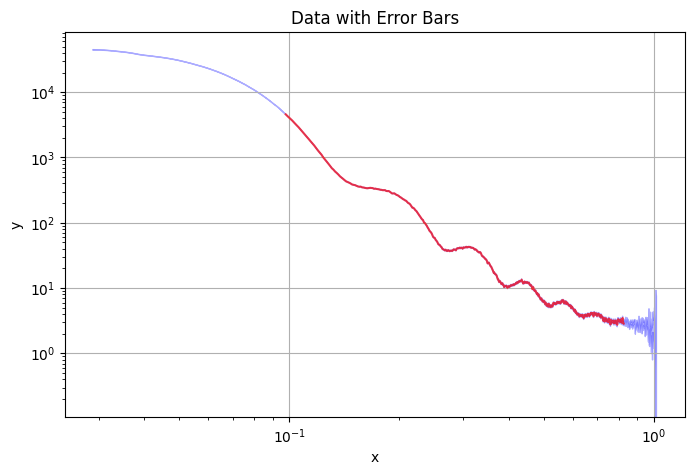

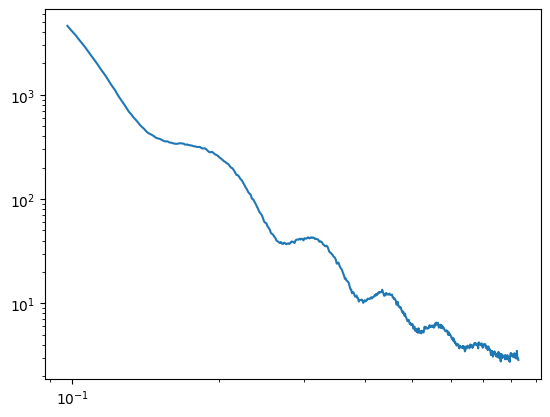

In [4]:
# Read measured data 

data = np.loadtxt("/messung/kmc/daten/2025/25_kw32/saxs_25_kw32/hdf_fcm_2025kw32_00097_Sample-Y_-8.0_Sample-X_44.7.dat")
# data = np.loadtxt("/messung/kmc/daten/2025/25_kw32/saxs_25_kw32/hdf_fcm_2025kw32_00097_Sample-Y_-8.0_Sample-X_39.8.dat")

x0 = 50
x_end = 580
print(len(data))
x = data[:,0]
y = data[:,1]
yerr = data[:,3]

plt.figure(figsize=(8,5))
# plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=3, ecolor='red', markerfacecolor='blue', markersize=4)
# plt.plot(x, y, 'b-', label='y', alpha=0.3)
plt.fill_between(x, y - yerr, y + yerr, color='blue', alpha=0.3, label='uncertainty')
plt.plot(x[x0:x_end], y[x0:x_end], 'r-', label='y', alpha=0.7)
plt.xlabel("x")
plt.ylabel("y")
plt.yscale("log")
plt.xscale("log")
plt.title("Data with Error Bars")
plt.grid(True)
plt.show()

data = data[x0:x_end,:]

fig, ax = plt.subplots()
ax.loglog(data[:,0], data[:,1])

# create, show and export ideal pentagonal bipyramid

base_corners = 5
side_length = 1
height = side_length * 0.1 * np.sqrt(50-10*np.sqrt(5))
radius = side_length / (2*np.sin(np.pi/base_corners))
fillet_radius = radius * 0.0
port = 3940

bipy = bipyramid(fillet_radius=fillet_radius, R=radius, h=height, base_corners=base_corners)

# show(bipy, port=port)

# export_stl(bipy, "stl/bipy.stl")

The true model is shown as the thick grey line and the effect of the
underestimated uncertainties is obvious when you look at this figure.
The standard way to fit a line to these data (assuming independent Gaussian
error bars) is linear least squares.
Linear least squares is appealing because solving for the parameters—and
their associated uncertainties—is simply a linear algebraic operation.
Following the notation in [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686), the linear least squares solution to these
data is

In [31]:
# A = np.vander(x, 2)
# C = np.diag(yerr * yerr)
# ATA = np.dot(A.T, A / (yerr**2)[:, None])
# cov = np.linalg.inv(ATA)
# w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
# print("Least-squares estimates:")
# print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
# print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
# plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
# plt.legend(fontsize=14)
# plt.xlim(0, 10)
# plt.xlabel("x")
# plt.ylabel("y");

This figure shows the least-squares estimate of the line parameters as a dashed line.
This isn't an unreasonable result but the uncertainties on the slope and
intercept seem a little small (because of the small error bars on most of the
data points).

## Maximum likelihood estimation

The least squares solution found in the previous section is the maximum
likelihood result for a model where the error bars are assumed correct,
Gaussian and independent.
We know, of course, that this isn't the right model.
Unfortunately, there isn't a generalization of least squares that supports a
model like the one that we know to be true.
Instead, we need to write down the likelihood function and numerically
optimize it.
In mathematical notation, the correct likelihood function is:

$$
    \ln\,p(y\,|\,x,\sigma,m,b,f) =
    -\frac{1}{2} \sum_n \left[
        \frac{(y_n-m\,x_n-b)^2}{s_n^2}
        + \ln \left ( 2\pi\,s_n^2 \right )
    \right]
$$

where

$$
    s_n^2 = \sigma_n^2+f^2\,(m\,x_n+b)^2 \quad .
$$

This likelihood function is simply a Gaussian where the variance is
underestimated by some fractional amount:  $f$.
In Python, you would code this up as:

In [32]:
# def log_likelihood(theta, x, y, yerr):
#     m, b, log_f = theta
#     model = m * x + b
#     sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
#     return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [6]:

# N=30000
# base_corners = 5
# side_length = (2*np.sin(np.pi/base_corners)) # then radius = 1
# height = side_length * 0.1 * np.sqrt(50-10*np.sqrt(5))
# radius = side_length / (2*np.sin(np.pi/base_corners))
# fillet_radius = radius * 0.0

# def bipy_curve(fillet_radius, radius, height, base_corners=5, N=30000):
#     # radius = max(radius, 1e-8)
#     # height = max(height, 1e-8)
#     base_corners = int(base_corners)
#     bipy = bipyramid(fillet_radius=fillet_radius, R=radius, h=height, base_corners=base_corners)
#     mesh = build123d_to_mesh(bipy)
#     cloud = CDEF.stl_cloud(mesh, N, sequence='halton')
#     curve = CDEF.scattering_mono(cloud, selfcorrelation=True)
#     return curve

# def log_likelihood(theta, x, y, yerr):
#     m, b, log_f = theta
#     model = m * x + b
#     sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
#     return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# bipy_curve(fillet_radius=fillet_radius, radius=radius, height=height, base_corners=base_corners, N=N)
# # print(0.1 * np.sqrt(50-10*np.sqrt(5)) * 2)
# print( ( np.sqrt(radius**2-(side_length/2)**2) + radius) / 2 )

# base_corners = int(base_corners)
# bipy = bipyramid(fillet_radius=fillet_radius, R=radius, h=height, base_corners=base_corners)
# mesh = build123d_to_mesh(bipy)
# print(len(mesh))

# # %timeit bipy_curve(fillet_radius, radius, height, base_corners=5, N=30000)

0.9045084971874737
10


### With bounds (not used!)
Bounds are necessary when introducing the fillet radius. When introducing bounds, the parameter space is searched differently, leading to bad results when the orders of magnitude in the arguments are too wide apart. Therefore here the N_C is first scaled to be on the same order as the rest.

In [34]:
%load_ext autoreload
%autoreload 2

import CDEF

distribution = 'lognormal'
N_C, mean, sigma, c0 =  30e-7, 50, 2, 0
N_C_1e7scaled = N_C * 1e7
data_1e7scaled = data.copy()
data_1e7scaled[:,1:] *= 1e7  # scale data to match N_C scaling


inital_guess = N_C_1e7scaled, mean, sigma, c0
unitmodel_args = {'N': N,
                  'base_corners': base_corners,
                  'radius': radius,
                  'height': height,
                  'fillet_radius': fillet_radius}
unitscattering = bipy_curve(**unitmodel_args)

tic = time.time()
fit_result = scipy.optimize.minimize(CDEF.chi_squared, (inital_guess), args=(data_1e7scaled, unitscattering, distribution), 
                                     method = 'Powell', options={'disp' : True},
                                     bounds = [(0, None),  # N_C
                                                (0, None),     # R0
                                                (0, None),     # sigma
                                                (0, 1.5)]     # c0
            )
toc = time.time()
print('Calculation time = {} s'.format(toc-tic))
print(f'fit results = {fit_result.x}')
print(f'chi_squared = {CDEF.chi_squared(fit_result.x, data_1e7scaled, unitscattering, distribution)}')




# distribution = 'lognormal'
# N_C, mean, sigma, c0 =  30e-7, 50, 2, 0

# inital_guess = N_C_1e7scaled, mean, sigma, c0, fillet_radius
# unitmodel_args = {'N': N,
#                   'base_corners': base_corners,
#                   'radius': radius,
#                   'height': height}

# tic = time.time()
# fit_result = scipy.optimize.minimize(CDEF.chi_squared_model, (inital_guess), args=(data, bipy_curve, unitmodel_args, distribution), 
#                                      method = 'Powell', options={'disp' : True},
#                                      bounds = [(0, None),  # N_C
#                                                 (0, None),     # mean
#                                                 (0, None),     # sigma
#                                                 (0, 1.5),     # c0
#                                                 (0.0, 0.3*radius)]    # fillet_radius
#             )
# toc = time.time()

# unitscattering = bipy_curve(fit_result.x[4], **unitmodel_args)

# print('Calculation time = {} s'.format(toc-tic))
# print(f'fit results = {fit_result.x}')
# print(f'chi_squared = {CDEF.chi_squared_model(fit_result.x, bipy_curve, unitmodel_args, distribution)}')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyboardInterrupt: 

### Without bounds
Without bounds the minimization works better. For now we keep this version and ignore fillets. No scaling of N_C is needed here currently (as opposed to the case above).

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
unitscattering calculation time = 0.24566411972045898 s
Optimization terminated successfully.
         Current function value: 6.152457
         Iterations: 14
         Function evaluations: 566
Calculation time = 19.190853118896484 s
fit results = [1.74002891e-07 4.68386110e+01 2.23329687e+00 7.63946942e-01]
chi_squared = 6.152457431590893
mean radius = 51.8 nm
mean side length = 60.9 nm


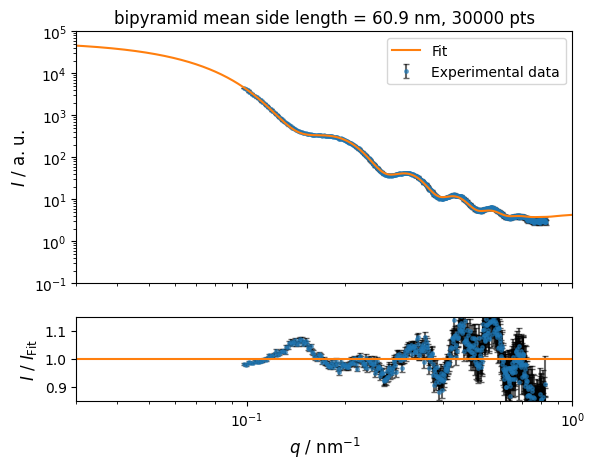

In [ ]:
%load_ext autoreload
%autoreload 2

import CDEF

N = 30000

distribution = 'lognormal'
N_C, mean, sigma, c0 =  3e-8, 50, 1, 1
inital_guess = N_C, mean, sigma, c0

unitmodel_args = {'N': N,
                  'base_corners': base_corners,
                  'radius': radius,
                  'height': height,
                  'fillet_radius': fillet_radius}

tic = time.time()
unitscattering = bipy_curve(**unitmodel_args)
print('unitscattering calculation time = {} s'.format(time.time()-tic))
fit_result = scipy.optimize.minimize(CDEF.chi_squared, (inital_guess), args=(data, unitscattering, distribution), 
                                     method = 'Powell', options={'disp' : True})
toc = time.time()
print('Calculation time = {} s'.format(toc-tic))
print(f'fit results = {fit_result.x}')
print(f'chi_squared = {CDEF.chi_squared(fit_result.x, data, unitscattering, distribution)}')


r_mean = fit_result.x[1]
r_bipy = 2*r_mean / (1 + np.cos(np.pi/5))
e_bipy = 2*r_bipy * np.sin(np.pi/5)
print(f"mean radius = {r_bipy:.1f} nm")
print(f"mean side length = {e_bipy:.1f} nm")

# fit_result = scipy.optimize.minimize(CDEF.chi_squared_model, (inital_guess), args=(data, bipy_curve, unitmodel_args, distribution), 
#                                      method = 'Powell', options={'disp' : True})
# toc = time.time()
# print('Calculation time = {} s'.format(toc-tic))
# print(f'fit results = {fit_result.x}')
# print(f'chi_squared = {CDEF.chi_squared_model(fit_result.x, data, bipy_curve, unitmodel_args, distribution)}')


plot_fitresults(data, fit_result.x, unitmodel_args, distribution, N)

In [ ]:
%load_ext autoreload
%autoreload 2

import CDEF

N = 30000

distribution = 'lognormal'
N_C, mean, sigma, c0 =  3e-7, 47, 2, 0
inital_guess = N_C, mean, sigma, c0

unitmodel_args = {'N': N,
                  'base_corners': base_corners,
                  'radius': radius,
                  'height': height,
                  'fillet_radius': fillet_radius}

tic = time.time()
# unitscattering = bipy_curve(**unitmodel_args)
# print('unitscattering calculation time = {} s'.format(time.time()-tic))
# fit_result = scipy.optimize.minimize(CDEF.chi_squared, (inital_guess), args=(data, unitscattering, distribution), 
#                                      method = 'Powell', options={'disp' : True})
# toc = time.time()
# print('Calculation time = {} s'.format(toc-tic))
# print(f'fit results = {fit_result.x}')
# print(f'chi_squared = {CDEF.chi_squared(fit_result.x, data, unitscattering, distribution)}')


fit_result = scipy.optimize.minimize(CDEF.chi_squared_model, (inital_guess), args=(data, bipy_curve, unitmodel_args, distribution), 
                                     method = 'Powell', options={'disp' : True})
first_fit = np.copy(fit_result.x)
toc = time.time()
print('Calculation time = {} s'.format(toc-tic))
print(f'fit results = {fit_result.x}')
print(f'chi_squared = {CDEF.chi_squared_model(fit_result.x, data, bipy_curve, unitmodel_args, distribution)}')

r_mean = fit_result.x[1]
r_bipy = 2*r_mean / (1 + np.cos(np.pi/5))
e_bipy = 2*r_bipy * np.sin(np.pi/5)
print(f"mean radius = {r_bipy:.1f} nm")
print(f"mean side length = {e_bipy:.1f} nm")

plot_fitresults(data, fit_result.x, unitmodel_args, distribution, N)

Optimization terminated successfully.
         Current function value: 11.536139
         Iterations: 2
         Function evaluations: 140
Calculation time = 106.45527935028076 s
fit results = [1.33613497e-07 4.40722671e+01 2.01311351e+00 1.67687607e+00]
chi_squared = 13.310473658898994
mean radius = 48.7 nm
mean side length = 57.3 nm


KeyError: 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_6594/3760604526.py:34: OptimizeWarning: Initial guess is not within the specified bounds
  fit_result = scipy.optimize.minimize(CDEF.chi_squared_model, (inital_guess), args=(data, bipy_curve, unitmodel_args, distribution),


Optimization terminated successfully.
         Current function value: 12.899431
         Iterations: 3
         Function evaluations: 227
Calculation time = 38.545249938964844 s
fit results = [1.66376837e-07 4.65557720e+01 1.98777096e+00 1.62732589e+00]
chi_squared = 78.45628470781296
mean radius = 51.5 nm
mean side length = 60.5 nm


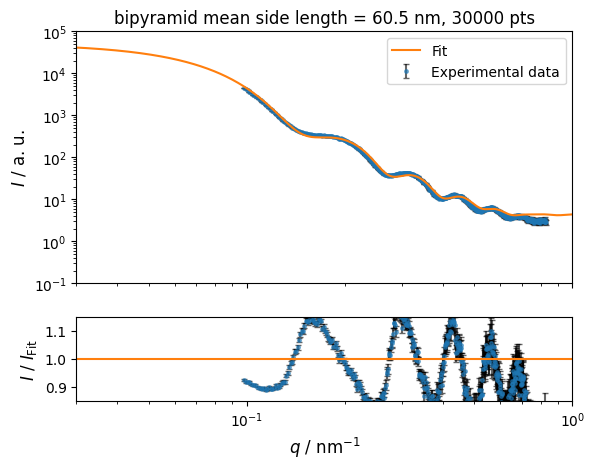

In [88]:
%load_ext autoreload
%autoreload 2

import CDEF

N = 30000

distribution = 'lognormal'
N_C, mean, sigma, c0 =  3e-7, 47, 2, 0
inital_guess = N_C, mean, sigma, c0

unitmodel_args = {'N': N,
                  'base_corners': base_corners,
                  'radius': radius,
                  'height': height,
                  'fillet_radius': fillet_radius}

tic = time.time()
# unitscattering = bipy_curve(**unitmodel_args)
# print('unitscattering calculation time = {} s'.format(time.time()-tic))
# fit_result = scipy.optimize.minimize(CDEF.chi_squared, (inital_guess), args=(data, unitscattering, distribution), 
#                                      method = 'Powell', options={'disp' : True})
# toc = time.time()
# print('Calculation time = {} s'.format(toc-tic))
# print(f'fit results = {fit_result.x}')
# print(f'chi_squared = {CDEF.chi_squared(fit_result.x, data, unitscattering, distribution)}')
bounds_rel = 0.1
bounds = [(first_fit[0]*(1-bounds_rel), first_fit[0]*(1+bounds_rel)),  # N_C
          (first_fit[1]*(1-bounds_rel), first_fit[1]*(1+bounds_rel)),     # R0
          (first_fit[2]*(1-bounds_rel), first_fit[2]*(1+bounds_rel)),     # sigma
          (first_fit[3]*(1-bounds_rel), first_fit[3]*(1+bounds_rel)) # c0)
          ]

fit_result = scipy.optimize.minimize(CDEF.chi_squared_model, (inital_guess), args=(data, bipy_curve, unitmodel_args, distribution), 
                                     method = 'Powell', options={'disp' : True}, bounds=bounds)

toc = time.time()
print('Calculation time = {} s'.format(toc-tic))
print(f'fit results = {fit_result.x}')
print(f'chi_squared = {CDEF.chi_squared_model(fit_result.x, data, bipy_curve, unitmodel_args, distribution)}')

r_mean = fit_result.x[1]
r_bipy = 2*r_mean / (1 + np.cos(np.pi/5))
e_bipy = 2*r_bipy * np.sin(np.pi/5)
print(f"mean radius = {r_bipy:.1f} nm")
print(f"mean side length = {e_bipy:.1f} nm")

plot_fitresults(data, fit_result, unitscattering, distribution, N)

## Try with all params including fillet_radius and scaling!

In [ ]:
from scipy.optimize import minimize

def scaled_objective(x_scaled, *args):
    # Convert scaled parameters back to physical space
    x = x_scaled * scales
    return CDEF.neg_log_likelihood_model(x, *args)


N = 30000

distribution = 'lognormal'
N_C, mean, sigma, c0, log_f, fillet_radius =  1.6e-7, 47, 1, 0.5, -5, 0.1
inital_guess = N_C, mean, sigma, c0, log_f, fillet_radius
bounds_rel = 0.1
bounds = [(first_fit[0]*(1-bounds_rel), first_fit[0]*(1+bounds_rel)),  # N_C
          (first_fit[1]*(1-bounds_rel), first_fit[1]*(1+bounds_rel)),     # R0
          (first_fit[2]*(1-bounds_rel), first_fit[2]*(1+bounds_rel)),     # sigma
          (first_fit[3]*(1-bounds_rel), first_fit[3]*(1+bounds_rel)) # c0)
          ]
bounds.append((-10,0)) # log_f
bounds.append((1e-3, 0.3)) # fillet_radius
# bounds = [(1e-8, 1e-6),  # N_C
#           (0, 100),     # R0
#           (0, 5),     # sigma
#           (0, 5), # c0)
#           (None, None), # log_f
#           (1e-3, 0.5) # fillet_radius
#           ]

unitmodel_args = {'N': N,
                  'base_corners': base_corners,
                  'radius': radius,
                  'height': height}

scales = np.array([1e-7, 10, 1, 1, 1, 1])  # typical scale per parameter
inital_guess_scaled = inital_guess / scales
bounds_scaled = [(lo/scale if lo is not None else None,
                  hi/scale if hi is not None else None)
                 for (lo, hi), scale in zip(bounds, scales)]

# Store path
path = []

def store_path(xk):
    path.append(np.copy(xk)) # Store a copy of the current parameters

tic = time.time()
# fit_result = scipy.optimize.minimize(CDEF.chi_squared_model, (inital_guess), args=(data, bipy_curve, unitmodel_args, distribution), 
#                                      method = 'Powell', options={'disp' : True})
method = 'L-BFGS-B' # Powell, L-BFGS-B, TNC, trust-constr, Nelder-Mead
fit_result = minimize(scaled_objective, inital_guess_scaled, args=(data, bipy_curve, unitmodel_args, distribution),
                      method = method, options={'disp' : True},
                      bounds = bounds_scaled,
                      callback=store_path)
best_fit = fit_result.x * scales

toc = time.time()
print('Calculation time = {} s'.format(toc-tic))
print(f'fit results = {best_fit}')
# print(f'chi_squared = {CDEF.chi_squared_model(best_fit[:4], data, bipy_curve, unitmodel_args, distribution)}')

r_mean = best_fit[1]
r_bipy = 2*r_mean / (1 + np.cos(np.pi/5))
e_bipy = 2*r_bipy * np.sin(np.pi/5)
print(f"mean radius = {r_bipy:.1f} nm")
print(f"mean side length = {e_bipy:.1f} nm")


plot_fitresults(data, best_fit, unitmodel_args, distribution, N)
plot_paths(path)


/tmp/ipykernel_25559/1625541412.py:51: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  fit_result = minimize(scaled_objective, inital_guess_scaled, args=(data, bipy_curve, unitmodel_args, distribution),


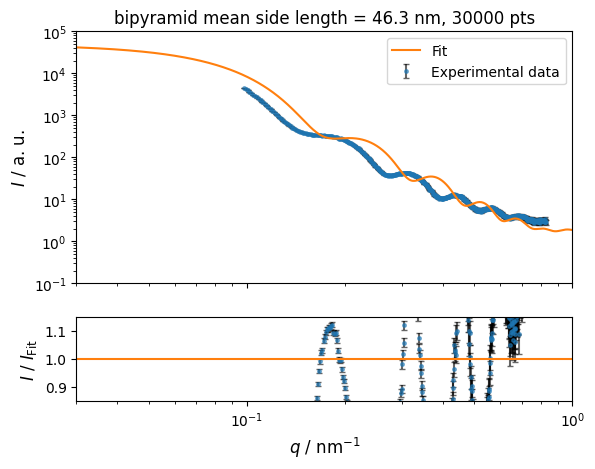

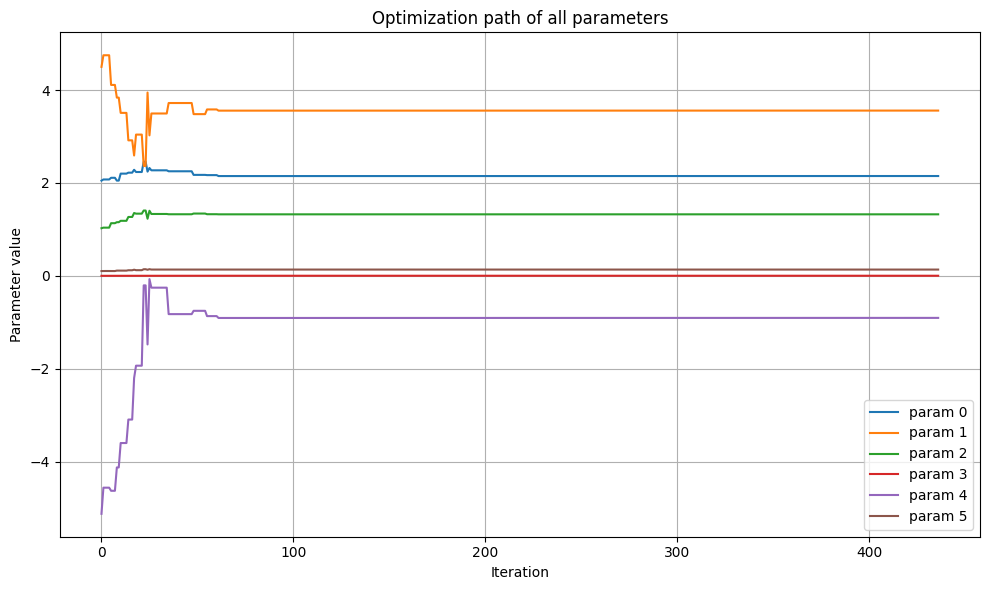

In [23]:
plot_fitresults(data, best_fit, unitmodel_args, distribution, N)
plot_paths(path)

In [ ]:
# Store path
path = []

def callback(theta):
    path.append(np.copy(theta))

res = minimize(objective, x0=[0, 0], method='Powell', callback=callback)

path = np.array(path)
print("Result:", res.x)

# Plot the "chain" of optimization steps
plt.figure(figsize=(6, 4))
plt.plot(path[:, 0], path[:, 1], '-o', label="Optimization path")
plt.scatter(*res.x, c='red', label="Minimum")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Powell Optimization Path")
plt.show()

chi_squared = 98.27287361916063
neg_log_likelihood = 15424.99385432901


In [ ]:
# print(15424.99385432901/98.27287361916063)
# print(116144.54544247717/424.3313253749992)
# print(neg_log_likelihood(fit_result.x, data, bipy_curve, unitmodel_args, distribution)/CDEF.chi_squared_model(fit_result.x[:-1], data, bipy_curve, unitmodel_args, distribution))

156.96085080513552
257.3754429690592


In [ ]:
# print(f'chi_squared = {CDEF.chi_squared_model(fit_result.x[:-1], data, bipy_curve, unitmodel_args, distribution)}')
# print(f'neg_log_likelihood = {neg_log_likelihood(fit_result.x, data, bipy_curve, unitmodel_args, distribution)}')

chi_squared = 424.3313253749992
neg_log_likelihood = 116144.54544247717


Optimization terminated successfully.
         Current function value: 513.128587
         Iterations: 14
         Function evaluations: 863
Calculation time = 28.32364773750305 s
fit results = [ 1.36827123e-07  4.72092059e+01  1.66166134e+00  6.42536163e-01
 -3.09782464e+00]
chi_squared = 100.07829133170247
mean radius = 52.2 nm
mean side length = 61.4 nm


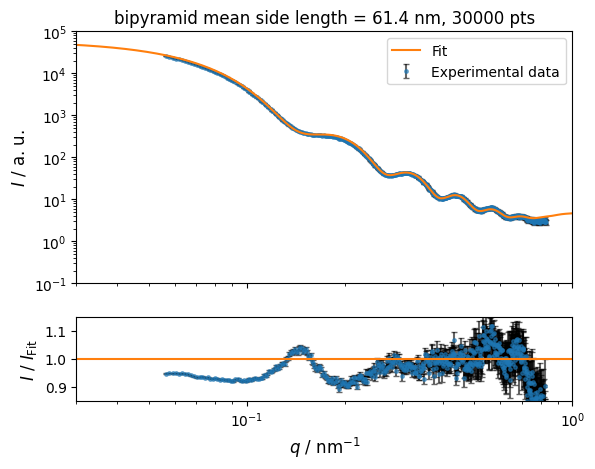

In [ ]:
from scipy.optimize import minimize

def neg_log_likelihood(params, data, unitscattering, distribution):
    """
    theta: array of parameters [N_C, R0, sigma, c0, ...model_params, log_f]
    data: (n,3) array with columns [q, I, Ierr]
    model: function for unit scattering
    distribution: type of distribution (e.g. Gaussian)
    """

    # Unpack parameters
    N_C, R0, sigma, c0, log_f  = params

    q = data[:, 0]
    I = data[:, 1]
    Ierr = data[:, 3]

    # Compute theoretical intensity
    I_Mod = CDEF.scattering_model(unitscattering, q, N_C, R0, sigma, c0, distribution)[:, 1]
    # I_Mod = c0 + N_C * scattering_poly(unitscattering, q, R0, sigma, 3000, distribution)[:, 1]

    # Variance model (same form as linear example, adapt if needed)
    sigma2 = Ierr**2 + I_Mod**2 * np.exp(2 * log_f)

    # negative Gaussian log-likelihood
    return - (-0.5 * np.sum((I - I_Mod) ** 2 / sigma2 + np.log(sigma2)))


N = 30000

distribution = 'lognormal'
N_C, mean, sigma, c0, logf =  3e-7, 47, 2, 1, 0.0
inital_guess = N_C, mean, sigma, c0, logf

unitmodel_args = {'N': N,
                  'base_corners': base_corners,
                  'radius': radius,
                  'height': height,
                  'fillet_radius': fillet_radius}

tic = time.time()
# fit_result = scipy.optimize.minimize(CDEF.chi_squared_model, (inital_guess), args=(data, bipy_curve, unitmodel_args, distribution), 
#                                      method = 'Powell', options={'disp' : True})
unitscattering = bipy_curve(**unitmodel_args)

fit_result = minimize(neg_log_likelihood, inital_guess, args=(data, unitscattering, distribution),
                      method = 'Powell', options={'disp' : True})#,
                #       bounds = [(0, None),  # N_C
                #                 (0, None),     # R0
                #                 (0, None),     # sigma
                #                 (0, 2),
                #                 (-5, 5)]     # c0)
                # )

toc = time.time()
print('Calculation time = {} s'.format(toc-tic))
print(f'fit results = {fit_result.x}')
print(f'chi_squared = {CDEF.chi_squared_model(fit_result.x[:4], data, bipy_curve, unitmodel_args, distribution)}')

r_mean = fit_result.x[1]
r_bipy = 2*r_mean / (1 + np.cos(np.pi/5))
e_bipy = 2*r_bipy * np.sin(np.pi/5)
print(f"mean radius = {r_bipy:.1f} nm")
print(f"mean side length = {e_bipy:.1f} nm")




#q-range of fit
qvec = np.logspace(-3,0,1000)

fit = CDEF.scattering_model(unitscattering, qvec, *fit_result.x[:-1], distribution)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col', sharey='row', gridspec_kw={'height_ratios':[3,1]})

r = fit_result.x[1]
r_bipy = 2*r / (1 + np.cos(np.pi/5))
e_bipy = 2*r_bipy * np.sin(np.pi/5)

ax[0].set_title(f'bipyramid mean side length = {e_bipy:.1f} nm, {N} pts')
ax[0].set_xscale('log')
ax[0].set_ylabel(r'$I$ / a. u.', fontsize=12)
ax[0].set_yscale('log')

#Frame limits
ax[0].set_ylim([1e-1, 1e5])
ax[0].set_xlim([3e-2, 1e0])

ax[0].errorbar(data[:,0], data[:,1], 
            yerr = data[:,2], fmt='.', ecolor='k', 
            capsize= 2, capthick=1, alpha=0.6, markersize = 5, label = 'Experimental data', zorder=1)
ax[0].loglog(fit[:,0], fit[:,1], label='Fit')

ax[0].legend()

#########################################
ax[1].set_xlabel(r'$q$ / nm$^{-1}$', fontsize=12)
ax[1].set_ylabel(r'$I$ / $I_{\mathrm{Fit}}$', fontsize=12)

#Frame limits
ax[1].set_ylim([0.85, 1.15])

ax[1].errorbar(data[:, 0], data[:, 1]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
            yerr = data[:, 2]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
            fmt='.', ecolor='k', capsize= 2, capthick=1, alpha=0.6, markersize = 5, 
            label = 'Experimental data', zorder=1)

ax[1].plot(fit[:,0], fit[:,1]/fit[:,1], label='Fit')

plt.show()

In this code snippet, you'll notice that we're using the logarithm of $f$
instead of $f$ itself for reasons that will become clear in the next section.
For now, it should at least be clear that this isn't a bad idea because it
will force $f$ to be always positive.
A good way of finding this numerical optimum of this likelihood function is to
use the [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) module:

In [ ]:
# from scipy.optimize import minimize

# np.random.seed(42)
# nll = lambda *args: -log_likelihood(*args)
# initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
# soln = minimize(nll, initial, args=(x, y, yerr))
# m_ml, b_ml, log_f_ml = soln.x

# print("Maximum likelihood estimates:")
# print("m = {0:.3f}".format(m_ml))
# print("b = {0:.3f}".format(b_ml))
# print("f = {0:.3f}".format(np.exp(log_f_ml)))

# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
# plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
# plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
# plt.legend(fontsize=14)
# plt.xlim(0, 10)
# plt.xlabel("x")
# plt.ylabel("y")

It's worth noting that the optimize module *minimizes* functions whereas we
would like to maximize the likelihood.
This goal is equivalent to minimizing the *negative* likelihood (or in this
case, the negative *log* likelihood).
In this figure, the maximum likelihood (ML) result is plotted as a dotted black line—compared to
the true model (grey line) and linear least-squares (LS; dashed line).
That looks better!

The problem now: how do we estimate the uncertainties on *m* and *b*?
What's more, we probably don't really care too much about the value of *f* but
it seems worthwhile to propagate any uncertainties about its value to our
final estimates of *m* and *b*.
This is where MCMC comes in.

## Marginalization & uncertainty estimation

This isn't the place to get into the details of why you might want to use MCMC
in your research but it is worth commenting that a common reason is that you
would like to marginalize over some "nuisance parameters" and find an estimate
of the posterior probability function (the distribution of parameters that is
consistent with your dataset) for others.
MCMC lets you do both of these things in one fell swoop!
You need to start by writing down the posterior probability function (up to a
constant):

$$
    p (m,b,f\,|\,x,y,\sigma) \propto p(m,b,f)\,p(y\,|\,x,\sigma,m,b,f) \quad .
$$

We have already, in the previous section, written down the likelihood function

$$
p(y\,|\,x,\sigma,m,b,f)
$$

so the missing component is the "prior" function

$$
p(m,b,f) \quad .
$$

This function encodes any previous knowledge that we have about the
parameters: results from other experiments, physically acceptable ranges, etc.
It is necessary that you write down priors if you're going to use MCMC because
all that MCMC does is draw samples from a probability distribution and you
want that to be a probability distribution for your parameters.
This is important: **you cannot draw parameter samples from your likelihood
function**.
This is because a likelihood function is a probability distribution **over
datasets** so, conditioned on model parameters, you can draw representative
datasets (as demonstrated at the beginning of this exercise) but you cannot
draw parameter samples.

In this example, we'll use uniform (so-called "uninformative") priors on $m$,
$b$ and the logarithm of $f$.
For example, we'll use the following conservative prior on $m$:

$$
p(m) = \left \{\begin{array}{ll}
        1 / 5.5 \,, & \mbox{if}\,-5 < m < 1/2 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .
$$

In code, the log-prior is (up to a constant):

In [ ]:
# [ 9.27263156e-08  4.74539307e+01  1.08458309e+00  7.97293547e-01 -1.85880582e+00]

In [35]:
def log_prior(params, bounds):
    for i, p in enumerate(params):
        if bounds[i][0] > p or p > bounds[i][1]:
            return -np.inf
    return 0.0

Then, combining this with the definition of ``log_likelihood`` from above, the full
log-probability function is:

In [36]:

def log_probability(params, bounds, data, model, model_args, distribution='lognormal'):
    lp = log_prior(params, bounds)
    if not np.isfinite(lp):
        return -np.inf
    # return lp + log_likelihood(params, data)
    return lp + CDEF.neg_log_likelihood_model(params, data, model, model_args, distribution)

In [37]:
curr = np.copy(fit_result.x)
curr[2] = np.abs(curr[2])
bounds = [[curr[0]/10, curr[0]*10], # N_C
          [curr[1]*0.8, curr[1]*1.2], # mean
          [curr[2]/5, curr[2]*5], # std
          [0, curr[3]*5], # c0
          [-10, 0] # log_f
]
print(curr)
print(log_prior(curr, bounds))

[ 1.36827123e-07  4.72092059e+01  1.66166134e+00  6.42536163e-01
 -3.09782464e+00]
0.0


After all this setup, it's easy to sample this distribution using emcee.
We'll start by initializing the walkers in a tiny Gaussian ball around the
maximum likelihood result (I've found that this tends to be a pretty good
initialization in most cases) and then run 5,000 steps of MCMC.

In [66]:
import emcee

nwalkers = 10
nsteps = 10
ndim = len(curr)
pos = curr * (1 + 1e-1 * np.random.randn(nwalkers, ndim))

unitmodel_args = {'N': N,
                  'base_corners': base_corners,
                  'radius': radius,
                  'height': height,
                  'fillet_radius': fillet_radius}
# fit results = [ 1.36827123e-07  4.72092059e+01  1.66166134e+00  6.42536163e-01 -3.09782464e+00]
# N_C, R0, sigma, c0, log_f
# bounds = [[]]

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(bounds, data, bipy_curve, unitmodel_args, distribution)
)
tic = time.time()
sampler.run_mcmc(pos, nsteps, progress=True)
print(f"{nwalkers} walkers with {nsteps} steps in {time.time()-tic:.3g} s")

You must install the tqdm library to use progress indicators with emcee


10 walkers with 10 steps in 18.7 s


Let's take a look at what the sampler has done.
A good first step is to look at the time series of the parameters in
the chain.
The samples can be accessed using the {func}`EnsembleSampler.get_chain` method.
This will return an array
with the shape `(5000, 32, 3)` giving the parameter values for each walker
at each step in the chain.
The figure below shows the positions of each walker as a function of the
number of steps in the chain:

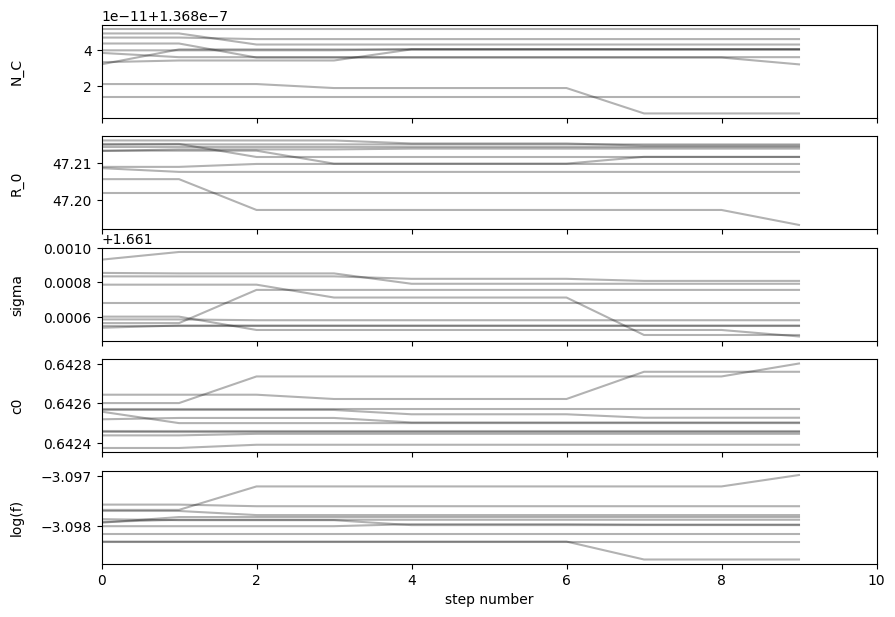

In [67]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["N_C", "R_0", "sigma", "c0", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

As mentioned above, the walkers start in small distributions around the
maximum likelihood values and then they quickly wander and start exploring the
full posterior distribution.
In fact, after fewer than 50 steps, the samples seem pretty well "burnt-in".
That is a hard statement to make quantitatively, but we can look at an estimate
of the integrated autocorrelation time (see the {ref}`autocorr` tutorial for more details):

In [63]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.74692192 1.04105602 0.80915339 0.6665998  0.69746304]

This suggests that only about 40 steps are needed for the chain to "forget" where it started.
It's not unreasonable to throw away a few times this number of steps as "burn-in".
Let's discard the initial 100 steps, thin by about half the autocorrelation time (15 steps), and flatten the chain so that we have a flat list of samples:

In [64]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(0, 5)


## Results

Now that we have this list of samples, let's make one of the most useful plots
you can make with your MCMC results: *a corner plot*.
You'll need the [corner.py module](http://corner.readthedocs.io) but
once you have it, generating a corner plot is as simple as:

In [65]:
import corner

fig = corner.corner(
    flat_samples, labels=labels
);

AssertionError: I don't believe that you want more dimensions than samples!

The corner plot shows all the one and two dimensional projections of the
posterior probability distributions of your parameters.
This is useful because it quickly demonstrates all of the covariances between
parameters.
Also, the way that you find the marginalized distribution for a parameter or
set of parameters using the results of the MCMC chain is to project the
samples into that plane and then make an N-dimensional histogram.
That means that the corner plot shows the marginalized distribution for each
parameter independently in the histograms along the diagonal and then the
marginalized two dimensional distributions in the other panels.

Another diagnostic plot is the projection of your results into the space of
the observed data.
To do this, you can choose a few (say 100 in this case) samples from the chain
and plot them on top of the data points:

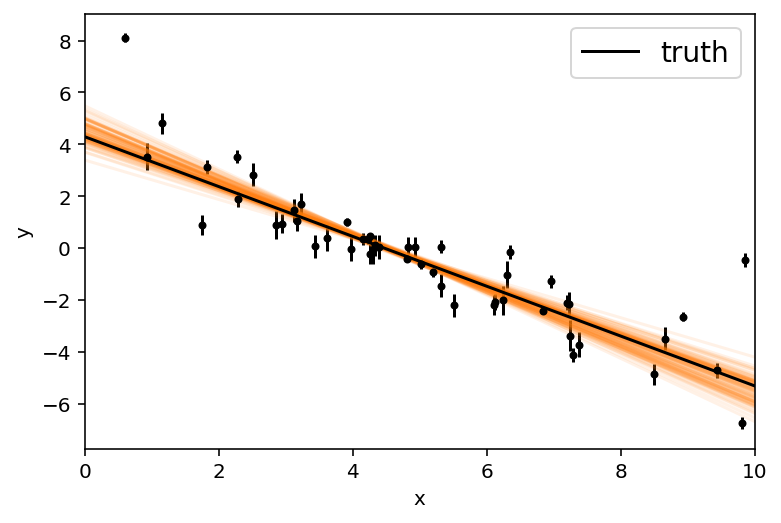

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

This leaves us with one question: which numbers should go in the abstract?
There are a few different options for this but my favorite is to quote the
uncertainties based on the 16th, 50th, and 84th percentiles of the samples in
the marginalized distributions.
To compute these numbers for this example, you would run:

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>